<a href="https://colab.research.google.com/github/sergiorivera50/HandsOnML-Notes/blob/master/End_to_End_Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [1]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

In [3]:
fetch_housing_data()
housing = load_housing_data()

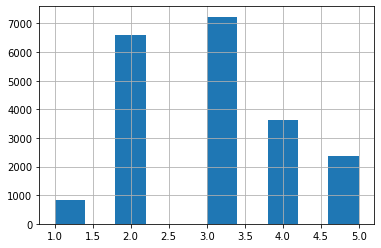

In [4]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#  Determines index for train and test arrays based on income_cat column
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [6]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [7]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_numerical = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_numerical)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [9]:
X = imputer.transform(housing_numerical)
housing_tr = pd.DataFrame(X, columns=housing_numerical.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


In [10]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [11]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self  # nothing else to do
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, 
                   bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline([
                               ("imputer", SimpleImputer(strategy="median")),
                               ("attribs_adder", CombinedAttributesAdder()),
                               ("std_scaler", StandardScaler()),
])

housing_numerical_tr = numerical_pipeline.fit_transform(housing_numerical)

In [14]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_numerical)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ("num", numerical_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

# Exercise

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def compute_scores(model, X, y, display=False, train=False):
  if train:
    model.fit(X, y)
  predictions = model.predict(X)
  mse = mean_squared_error(y, predictions)
  rmse = np.sqrt(mse)

  scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
  rmse_scores = np.sqrt(-scores)
  if display:
    print("RMSE: ", rmse)
    print("Cross-val Scores: ", rmse_scores)
    print("Mean: ", rmse_scores.mean())
    print("Std deviation: ", rmse_scores.std())
    print()

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


param_grid = [
              {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
              {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

randomized_search = RandomizedSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

randomized_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [17]:
best_model = randomized_search.best_estimator_
compute_scores(best_model, housing_prepared, housing_labels,
               display=True, train=True)

RMSE:  19375.537771345502
Cross-val Scores:  [49442.92724271 47238.99365822 49413.89613402 51201.77853631
 47891.67487017 52425.02827717 48222.19836139 47795.27580115
 51635.89380578 49401.96372559]
Mean:  49466.9630412519
Std deviation:  1681.0999928942101

